# The Titanic Dataset

## Framing the Problem

This is the infamous Titanic ML competition – the best, first challenge for beginners to dive into ML competitions and familiarize themselves with Kaggle. In this case, I'm actually working out of Aurélien Géron's book, *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow*. Exercise 3 of Chapter 3 is to complete this competition.

Of course, since I have been training with Mr. Géron's book, I will go through the Machine Learning Project Checklist.  The first step is to frame the problem and look at the big picture.

The objective is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. This isn't really a business problem per se, but studying the survival rate on the Titanic could prove useful for other ships in the modern day. For example, by knowing which groups were most likely to die on the Titanic, those groups could be targeted for immediate rescue if a comparable shipwreck were to happen today.

This problem will clearly be a supervised offline learning problem, since we know which passengers survived and which didn't. Further, we don't have any new information streaming into the problem.

Since this is a classification problem, performance of the algorithm should be measured via both precision and recall or accuracy. In the context of improving survival rates in future shipwrecks, an imprecise model would incorrectly categorize people and waste resources on people who perhaps don't need as much help to survive the shipwreck. On the other hand, an algorithm with low recall will miss people who really need help to survive. It doesn't seem like it's a good idea to sacrifice recall for precision, or vice versa, so we should aim to have both high.

The next thing on the checklist is to get the data.

## Get the Data

In [1]:
import os
import pandas as pd
import numpy as np

TITANIC_PATH = os.path.join('datasets')

def load_csv(PATH, file):
    csv_path = os.path.join(PATH, file)
    return pd.read_csv(csv_path)

titanic_train = load_csv(TITANIC_PATH, 'train.csv')
titanic_test = load_csv(TITANIC_PATH, 'test.csv')

The data have already been divided into training and testing sets, but they will need to be separated into the predictors and the labels. We can do this later.

Because this dataset is from a Kaggle competition, the test set does not have labels. Later we will submit a file of our predictions for evaluation.

## Exploring the Data

Now we move on to the third step, exploring the data. Taking a quick look at the data structure:

In [2]:
titanic_train = titanic_train.set_index("PassengerId")
titanic_test = titanic_test.set_index("PassengerId")

titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It looks like there are 12 attributes in the dataset, with survived being the label and everything else a predictor:

    - PassengerId: a unique identifier for each passenger
    - Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
    - Pclass: passenger class
    - Name, Sex, Age: self-explanatory
    - SibSp: how many siblings & spouses of the passenger aboard the Titanic
    - Parch: how many children & parents of the passenger aboard the Titanic
    - Ticket: ticket id
    - Fare: price paid (in pounds)
    - Cabin: passenger's cabin number
    - Embarked: where the passenger embarked the Titanic


In [3]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Looks like `age`, `cabin`, and `embarked` have `null` values in them. Further, we have a few attributes that are strings: `name`, `sex`, `ticket`, `cabin`, and `embarked`. We know that `Survived` and `Sex` are categorical attributes, but what about the rest?

In [4]:
print(titanic_train['Sex'].value_counts())
print(titanic_train['Embarked'].value_counts())
print(titanic_train['Pclass'].value_counts())

male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64


We have a few categories for the `Embarked` and `Pclass` attributes. The `Sex` attribute can be converted to numbers with OneHotEncoding later too.

In [5]:
titanic_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% of the passengers survived! We can also see that there is a large spread in age, with the oldest passenger being 80 years old and the youngest less than year, but the standard deviation is only 14.5 years.

Let's look at the data plotted against itself and see if we can see anything interesting.

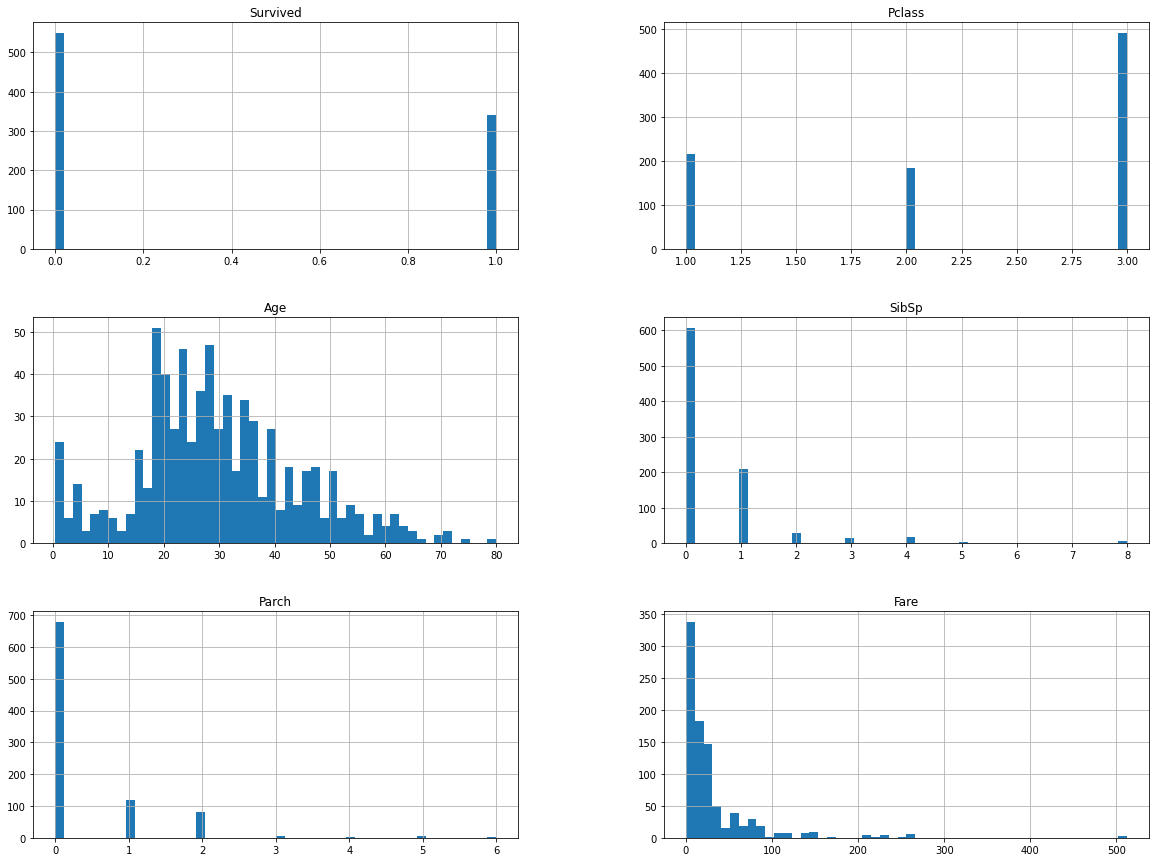

In [6]:
import matplotlib.pyplot as plt

titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Most passenegers traveled by themselves, as we can see in SibSp and Parch. The age distribution is almost normal, with most of the passengers being 20-30 years old. The fare price is heavily skewed to the left. We know that this attribute is expressed in Pounds and is not scaled at all. The scales of these data are not very different.

Now we'll split the data into predictors and labels and also make copies of the data that we can work on without disturbing the originals.

In [7]:
X_train, y_train = titanic_train.drop('Survived', axis=1), titanic_train['Survived']
X_test = titanic_test.copy()

X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preparing the Data for ML

Now we should start cleaning up this data, i.e. figuring out what to fill the null values with and if we should use all the predictors for training or not.

We have a couple attributes that have missing values: `age`, `cabin`, and `embarked`. I think that we can ignore the `cabin` attribute for now. For `age`, we can see that the distribution above is fairly normal, so the mean and median will be similar. We'll fill in the missing values with the median age. 

Further, we have a few attributes that are strings: `name`, `sex`, and `ticket`. I'm also going to ignore `name` and `ticket` for now. `sex` and `embarked` can be converted to categorical variables easily with `OneHotEncoder`.

So we need to remove `cabin`, `name`, and `ticket`. We'll create a custom transformer for this so that we can apply these transformations to the test set easily later:

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

name, ticket, cabin = 'Name', 'Ticket', 'Cabin'

# print(X_train.iloc[:, ticket])

class StringAttributeRemover(BaseEstimator, TransformerMixin):
    def __init__(self, remove_string_attributes=True):
        self.remove_string_attributes = remove_string_attributes
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # here is where we remove the attributes we don't want
        if self.remove_string_attributes:
            X = X.drop([name, ticket, cabin], axis=1)
        return X

# seeing if it works
# attr_remover = StringAttributeRemover()
# X_train_trim = attr_remover.transform(X_train)
# print(X_train_trim.head())

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

pipeline_1 = Pipeline([
    ('attribs_remover', StringAttributeRemover())
])

pipeline_2 = ColumnTransformer([
    ('nums', num_pipeline, num_attribs),
    ('cats', OneHotEncoder(), cat_attribs)
])

X_train_trim = pipeline_1.fit_transform(X_train)

X_train_prepared = pipeline_2.fit_transform(X_train_trim)

print(X_train_trim)
print(X_train_prepared.shape)  # should be 891, 

             Pclass     Sex   Age  SibSp  Parch     Fare Embarked
PassengerId                                                      
1                 3    male  22.0      1      0   7.2500        S
2                 1  female  38.0      1      0  71.2833        C
3                 3  female  26.0      0      0   7.9250        S
4                 1  female  35.0      1      0  53.1000        S
5                 3    male  35.0      0      0   8.0500        S
...             ...     ...   ...    ...    ...      ...      ...
887               2    male  27.0      0      0  13.0000        S
888               1  female  19.0      0      0  30.0000        S
889               3  female   NaN      1      2  23.4500        S
890               1    male  26.0      0      0  30.0000        C
891               3    male  32.0      0      0   7.7500        Q

[891 rows x 7 columns]
(891, 13)


## Shortlist Promising Models

Now that we have prepared the data for the machine learning model, we're going to train a couple of models with the standard parameters and then measure and compare their performances using N-fold cross validation.

In [10]:
from sklearn.linear_model import SGDClassifier

my_random_state = 5

sgd_clf = SGDClassifier(random_state=my_random_state)

sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=5)

In [11]:
from sklearn.model_selection import cross_val_score

sgd_cv = cross_val_score(sgd_clf, X_train_prepared, y_train, cv=10, n_jobs=10)

In [12]:
print(sgd_cv)

[0.68888889 0.82022472 0.71910112 0.83146067 0.75280899 0.7752809
 0.7752809  0.74157303 0.76404494 0.75280899]


In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=10, n_jobs=10)
print(confusion_matrix(y_train, y_train_pred))

[[485  64]
 [148 194]]


Based on the confusion matrix, we can see that the model correctly classified 485 people as having not survived, and 194 people as having survived. 64 people were classified as survived even though they died, and 148 people were said to have died, but actually survived!

Let's go ahead and try a RandomForestClassifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier

r_forest_clf = RandomForestClassifier(random_state=my_random_state)

r_forest_clf.fit(X_train_prepared, y_train)

r_forest_cv = cross_val_score(r_forest_clf, X_train_prepared, y_train, cv=10, n_jobs=10)

In [15]:
print(r_forest_cv)

[0.75555556 0.76404494 0.7752809  0.79775281 0.88764045 0.82022472
 0.82022472 0.76404494 0.80898876 0.83146067]


In [16]:
from sklearn.svm import SVC

svm_clf = SVC()

svm_clf.fit(X_train_prepared, y_train)

svm_cv = cross_val_score(svm_clf, X_train_prepared, y_train, cv=10, n_jobs=10)

print(svm_cv)

[0.8        0.84269663 0.76404494 0.86516854 0.82022472 0.78651685
 0.83146067 0.79775281 0.86516854 0.85393258]


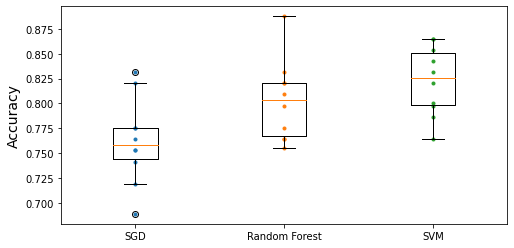

In [17]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, sgd_cv, ".")
plt.plot([2]*10, r_forest_cv, ".")
plt.plot([3]*10, svm_cv, ".")
plt.boxplot([sgd_cv, r_forest_cv, svm_cv], labels=("SGD","Random Forest", 'SVM'))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

Based on the box plots above of the cross validation scores achieved by each of the models, the best model is the Support Vector Machine one. Although the Random Forest Classifier achieved a better accuracy in one of its cross validation folds, the spread is much greater. The median accuracy for the Support Vector Machine is better and so this indicates that the model will generalize better than the other two models.

## Fine Tune the System

We can see if changing the hyperparameters on the SVM model can increase its accuracy.

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear', 'rbf'], 'C': [1.0, 5.0, 10.0, 20.0]}, 
]

grid_search = GridSearchCV(svm_clf, param_grid, cv=10, scoring='accuracy', return_train_score=True, n_jobs=10)

grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=10,
             param_grid=[{'C': [1.0, 5.0, 10.0, 20.0],
                          'kernel': ['linear', 'rbf']}],
             return_train_score=True, scoring='accuracy')

In [19]:
print(grid_search.best_params_)

for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(mean_score, params)

{'C': 5.0, 'kernel': 'rbf'}
0.786729088639201 {'C': 1.0, 'kernel': 'linear'}
0.8226966292134831 {'C': 1.0, 'kernel': 'rbf'}
0.786729088639201 {'C': 5.0, 'kernel': 'linear'}
0.8271910112359551 {'C': 5.0, 'kernel': 'rbf'}
0.786729088639201 {'C': 10.0, 'kernel': 'linear'}
0.8115106117353308 {'C': 10.0, 'kernel': 'rbf'}
0.786729088639201 {'C': 20.0, 'kernel': 'linear'}
0.8036579275905117 {'C': 20.0, 'kernel': 'rbf'}


So the best hyperparameters for the SVM classifier are `C=5.0` and `kernel=rbf` which yield an average accuracy over the 10 cross validation folds of 82.7%. This is pretty good!

Now that we are armed with this classification model, let's run the test set through the transformation pipeline and then use the model to generate predictions.

In [20]:
# push the test set through the transformation pipeline, making sure to use transform() not fit_transform()
X_test_trim = pipeline_1.transform(X_test)
X_test_prepared = pipeline_2.transform(X_test_trim)

print(X_test_trim)
print(X_test_prepared.shape)

             Pclass     Sex   Age  SibSp  Parch      Fare Embarked
PassengerId                                                       
892               3    male  34.5      0      0    7.8292        Q
893               3  female  47.0      1      0    7.0000        S
894               2    male  62.0      0      0    9.6875        Q
895               3    male  27.0      0      0    8.6625        S
896               3  female  22.0      1      1   12.2875        S
...             ...     ...   ...    ...    ...       ...      ...
1305              3    male   NaN      0      0    8.0500        S
1306              1  female  39.0      0      0  108.9000        C
1307              3    male  38.5      0      0    7.2500        S
1308              3    male   NaN      0      0    8.0500        S
1309              3    male   NaN      1      1   22.3583        C

[418 rows x 7 columns]
(418, 13)


In [21]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test_prepared)

print(final_predictions)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0
 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


Great! We've used our SVM Classifier model to generate predictions on the passengers in the test set. In order to submit our predictions to Kaggle, we need to have the data in a two-column table, with the first column being the passenger IDs and the second column being the survival prediction. We can generate a pandas DataFrame and then export it to a CSV file.

In [22]:
d = {'PassengerID': X_test.index, 'Survived': final_predictions}
df = pd.DataFrame(data=d)

print(df.head(10))

   PassengerID  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0


In [25]:
output_file = os.path.join(TITANIC_PATH, 'predictions.csv')
df.to_csv(output_file, index=False)

We end up with a score of 0.76555, or 76.555% of the passengers' survival was predicted correctly. There are some other things we can do with the dataset that could probably help our model's accuracy, like some feature engineering or using some of the features that we ignored in creative ways. For example, maybe a person's name is somewhat indicative of nationality, and that could help with classification. Or, we could bin the passengers' ages and create an age group category.

## Update 1 October 2022, Adding an ROC Curve

The receiver operating characteristic (ROC) curve plots the true positive rate against the false positive rate.

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve()